# Init process: import libraries, load datasets and evaluate data for next phases

Import ncessary libraries.

In [84]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import copy
%matplotlib inline
%run utility.ipynb

Load dataset about total deaths, new deaths, total cases and new cases.

In [3]:
#load full dataset of coronavirus from internet
df_all_data__ = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
#rename columns with more meaningful name
df_all_data__.rename(columns={"location": "Country","date":"Date", "new_cases":"New cases",
                            "new_deaths":"New deaths","total_cases":"Total cases", 
                            "total_deaths":"Total deaths"}, inplace = True)
df_all_data__.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths
12500,2020-04-18,Zimbabwe,0,0,24,3
12501,2020-04-19,Zimbabwe,1,0,25,3
12502,2020-04-20,Zimbabwe,0,0,25,3
12503,2020-04-21,Zimbabwe,0,0,25,3
12504,2020-04-22,Zimbabwe,3,0,28,3


Load population dataset. The dataset is updated with 2020 data. 
It has been downloaded from:
https://www.kaggle.com/tanuprabhu/population-by-country-2020.

It is currently saved locally.
The dataset contains for each country the number of inhabitants. This dataset is used later to plot covid-19 deaths and cases basing on number of inhabitants.

In [4]:
#load population dataset keeping only the necessary columns 
#(countries and number of inhabitants) renaiming them
df_population = pd.read_csv("./world_analysis/dataset/population_by_country_2020.csv")
df_population = df_population[['Country (or dependency)','Population (2020)']]
df_population.drop_duplicates(inplace = True)
df_population.rename(columns={"Country (or dependency)": "Country",
                            "Population (2020)":"Population"}, inplace = True)
df_population.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


Load lockdown dataset. The dataset has been downloaded from:
https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country#countryLockdowndates.csv.

It is currently saved locally.
It contains the following columns:
<ul>
<li>country</li>
<li>province of the country</li>
<li>date in which the lockdown has been put in place</li>
<li>type of lockdown (full or partial)</li>
<li>reference (source of the data).</li>
</ul>

The 'reference' column is dropped because it is not necessary during the analysis.

In [5]:
#load lockdown dataset
df_lockdown = pd.read_csv("./world_analysis/dataset/countryLockdowndates.csv")

#rename column relative to country
df_lockdown.rename(columns={"Country/Region": "Country","Date":"Beginning Date"}, inplace = True)
#convert string date format from 'dd/mm/yyyy' to 'yyyy-mm-dd'
df_lockdown['Beginning Date'] = pd.to_datetime(df_lockdown['Beginning Date'])
#rename country value from 'US' to 'United States' where needed
df_lockdown['Country'] = df_lockdown['Country'].apply(lambda x : 'United States' if x == 'US' else x)
#delete 'Reference column'
df_lockdown.drop('Reference', axis = 1, inplace = True)
#if value in 'Province' column is not present, 
#replace it with value in 'Country' column
df_lockdown.Province.fillna(df_lockdown.Country, inplace=True)
#keep only the country where the value in the Country column is equal 
#to the value in the Province column. In this way, it eliminates the
#rows reguarding colonies
df_lockdown = df_lockdown[df_lockdown.Province==df_lockdown.Country]
#drop the Province column because it is not necessary
df_lockdown.drop('Province', axis = 1, inplace = True)
df_lockdown.head()

,Country,Beginning Date,Type
0,Afghanistan,2020-03-24,Full
1,Albania,2020-03-08,Full
2,Algeria,2020-03-24,Full
3,Andorra,2020-03-16,Full
4,Angola,2020-03-24,Full


Load population density dataset. The dataset is downloaded from:
https://www.kaggle.com/fernandol/countries-of-the-world#countries%20of%20the%20world.csv

In [6]:
#load dataset
df_population_density_ = pd.read_csv("./world_analysis/dataset/population_density.csv")
df_population_density = df_population_density_[['Country','Pop. Density (per sq. mi.)']]
df_population_density.rename(columns = {'Pop. Density (per sq. mi.)': 'Population density'}, inplace = True)
#trim country value because original dataset has a space at the end
df_population_density['Country'] = df_population_density['Country'].apply(lambda x : x.strip())
df_population_density.head()

C:\Users\ellee\Anaconda3\envs\facenet\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\ellee\Anaconda3\envs\facenet\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,Population density
0,Afghanistan,48.0
1,Albania,124.6
2,Algeria,13.8
3,American Samoa,290.4
4,Andorra,152.1


Merge coronavirus dataset and population dataset.

In [7]:
df_all_data_ =df_all_data__.copy()
df_all_data_ = pd.merge (left = df_all_data_, right = df_population, on = 'Country')
df_all_data_ = pd.merge (left = df_all_data_, right = df_population_density, on = 'Country')
df_all_data_['Date'] = pd.to_datetime(df_all_data_['Date'])
df_all_data_.head()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density
0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0
1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0
2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0
3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0
4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0


Evaluate number of cases and deaths per million of inhabitants and store the information in new columns of the full dataset.

In [8]:
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New cases',
                                            'New cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total cases',
                                            'Total cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New deaths',
                                            'New deaths per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total deaths',
                                            'Total deaths per million of inhabitants')
df_all_data_.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants
10954,2020-04-18,Zimbabwe,0,0,24,3,14862924,31.3,0.000000,1.614756,0.0,0.201845
10955,2020-04-19,Zimbabwe,1,0,25,3,14862924,31.3,0.067282,1.682038,0.0,0.201845
10956,2020-04-20,Zimbabwe,0,0,25,3,14862924,31.3,0.000000,1.682038,0.0,0.201845
10957,2020-04-21,Zimbabwe,0,0,25,3,14862924,31.3,0.000000,1.682038,0.0,0.201845
10958,2020-04-22,Zimbabwe,3,0,28,3,14862924,31.3,0.201845,1.883882,0.0,0.201845


Add lockdown information in the full dataset. For each row, create a new column where if in the country for that date was not present the lockdown, the value is set to 0, if the lockdown is partial set a value of 1, if the lockdown is full, set the value to 2. 

In [55]:
#make a copy of the full dataset
#merge lockdown dataset with full dataset
df_all_data = df_all_data_.copy()
df_all_data = df_all_data.merge(df_lockdown, on='Country', how='left')

#create a new column setting an initial default value of -1.
#This value has no meaning. Its only a "jolly" value that evidences
#that the value hano not been set yet
df_all_data['Lockdown state'] = -1

#set a correct value for each row in the full dataset that depends
#on the lockdown type in that particula date for each country
for i in range(len(df_all_data)):
    if(df_all_data.iloc[i]['Type'] == 'None'):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    elif(df_all_data.iloc[i]['Date'] < df_all_data.iloc[i]['Beginning Date']):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    else:
        if(df_all_data.iloc[i]['Type'] == 'Full'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 2
        elif(df_all_data.iloc[i]['Type'] == 'Partial'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 1
        else:
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = -2


#drop Type column because it is not usefull now
del df_all_data['Type']



df_all_data

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state
0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0,0.000000,0.000000,0.0,0.000000,2020-03-24,0
1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0,0.000000,0.000000,0.0,0.000000,2020-03-24,0
2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0,0.000000,0.000000,0.0,0.000000,2020-03-24,0
3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0,0.000000,0.000000,0.0,0.000000,2020-03-24,0
4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0,0.000000,0.000000,0.0,0.000000,2020-03-24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10954,2020-04-18,Zimbabwe,0,0,24,3,14862924,31.3,0.000000,1.614756,0.0,0.201845,2020-03-27,2
10955,2020-04-19,Zimbabwe,1,0,25,3,14862924,31.3,0.067282,1.682038,0.0,0.201845,2020-03-27,2
10956,2020-04-20,Zimbabwe,0,0,25,3,14862924,31.3,0.000000,1.682038,0.0,0.201845,2020-03-27,2
10957,2020-04-21,Zimbabwe,0,0,25,3,14862924,31.3,0.000000,1.682038,0.0,0.201845,2020-03-27,2


# Data visualization

## Analysis by country without considering the number of inhabitants

Firstly, it would be interesting to compare the growth about the number of deaths and cases of some countries starting from a specific point, meant as a common starting point, for a better comparison. Next steps are used to estabilish which is the starting point.

In the first step it is necessary to retrieve what the top ten countries for number of deaths are.

In [11]:
#create a copy of the dataset keeping the necessary columns
df_total_deaths = df_all_data[['Country','Total deaths']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths = df_total_deaths.groupby('Country').max()
df_group_total_deaths.sort_values(by = 'Total deaths',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_deaths = df_group_total_deaths.iloc[0:10]
top_10_total_deaths.reset_index(inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths['Total deaths'].sum(), end ="\n\n")
top_10_total_deaths

World number of deaths: 176096



,Country,Total deaths
0,United States,45063
1,Italy,24648
2,Spain,21282
3,France,20796
4,United Kingdom,17337
5,Belgium,5998
6,Iran,5297
7,Germany,4879
8,China,4636
9,Netherlands,3916


Plot the total number of deaths, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

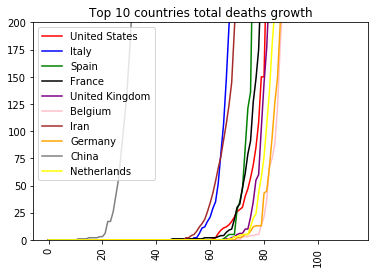

In [12]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth',
                            0, 200)

It is possible to set the starting point to 50 deaths, and this will be the common starting point for comparing the data.

Print data of the top 10 countries for number of deaths and plot the growth starting from the first 50 confirmed deaths.

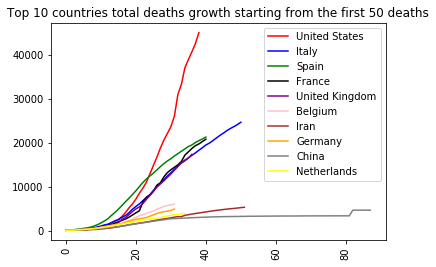

In [13]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            50)

The same procedure is used for confirmed cases.

First, retrieve information about top 10 countries for total number of cases.

In [14]:
#create a copy of the dataset keeping the necessary columns
df_total_cases = df_all_data[['Country','Total cases']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_cases = df_total_cases.groupby('Country').max()
df_group_total_cases.sort_values(by = 'Total cases',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases = df_group_total_cases.iloc[0:10]
top_10_total_cases.reset_index(inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases['Total cases'].sum(), end ="\n\n")
top_10_total_cases

World number of cases: 2495464



,Country,Total cases
0,United States,825041
1,Spain,204178
2,Italy,183957
3,Germany,145694
4,United Kingdom,129044
5,France,117324
6,Turkey,95591
7,Iran,84802
8,China,83864
9,Russia,52763


Plot the total number of cases, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

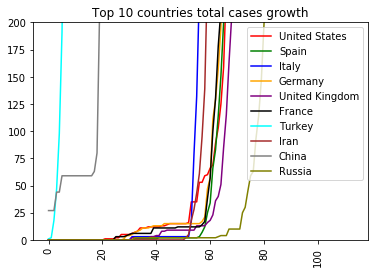

In [15]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'], 'Total cases',
                            'Top 10 countries total cases growth',
                            0, 200)

Because of a stabilization period in China around about 60 cases, this time, the starting point is set to 75 cases.

Print data of the top 10 countries for number of cases and plot the growth starting from the first 75 confirmed case.

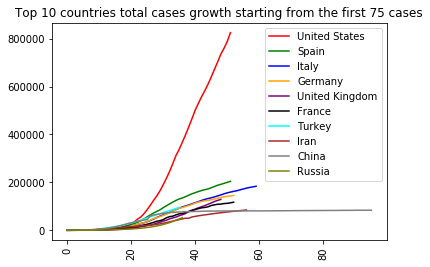

In [16]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'],'Total cases',
                            'Top 10 countries total cases growth starting from the first 75 cases',
                            75)

## Analysis by country considering the number of inhabitants

As done before, firstly, print data of top ten countries for total deaths.

In [17]:
#create a copy of the dataset
df_total_deaths_x_million = df_all_data[['Country',
                                         'Total deaths per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths_x_million = df_total_deaths_x_million.groupby('Country').max()
df_group_total_deaths_x_million.sort_values(by = 'Total deaths per million of inhabitants',ascending = False, inplace = True)


#loc the first 10 rows
top_10_total_deaths_x_million = df_group_total_deaths_x_million.iloc[0:10]
top_10_total_deaths_x_million.reset_index(inplace = True)
top_10_total_deaths_x_million

,Country,Total deaths per million of inhabitants
0,San Marino,1178.862987
1,Belgium,517.531934
2,Andorra,478.871417
3,Spain,455.183425
4,Italy,407.662183
5,France,318.597846
6,United Kingdom,255.383985
7,Netherlands,228.539787
8,Sweden,174.765193
9,Ireland,147.839538


Plot data day by day of the top 10 countries to try to detect a common starting point for comparing the growth focusing on a range between 0 and 20 cases per million of inhabitants.

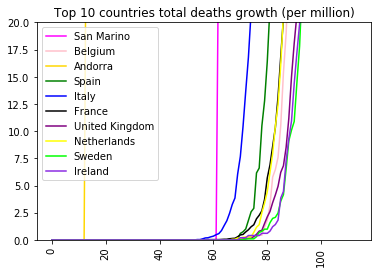

In [18]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth (per million)',
                            0, 20)

For some countries, such as Andorra and San Marino, there is not a slow growth but it has a very fast increase. A part these, it is possible to consider, as a common starting point, a value of 2.5.

Plot the growth starting from the point where the rate was upper than 2.5.

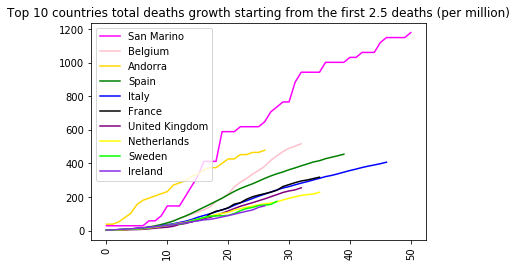

In [19]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth starting from the first 2.5 deaths (per million)',
                            2.5)

The growth is almost linear for the top 10 countries.

Print data of the top 10 countries for number of cases per million

In [20]:
#create a copy of the dataset
df_total_cases_x_million = df_all_data[['Country',
                                         'Total cases per million of inhabitants']].copy()


#get the maximum value of each country and sort the data in descendent way
df_group_total_cases_x_million = df_total_cases_x_million.groupby('Country').max()
df_group_total_cases_x_million.sort_values(by = 'Total cases per million of inhabitants',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases_x_million = df_group_total_cases_x_million.iloc[0:10]
top_10_total_cases_x_million.reset_index(inplace = True)
top_10_total_cases_x_million

,Country,Total cases per million of inhabitants
0,San Marino,14028.469541
1,Andorra,9279.751505
2,Luxembourg,5779.755838
3,Iceland,5210.363290
4,Spain,4366.997529
5,Gibraltar,3947.641803
6,Isle of Man,3610.363036
7,Belgium,3533.850929
8,Ireland,3248.419433
9,Switzerland,3233.070144


As done before, plot the growth to detect a common starting point for comparison focusing on a range between 0 and 20 cases per million of inhabitants.

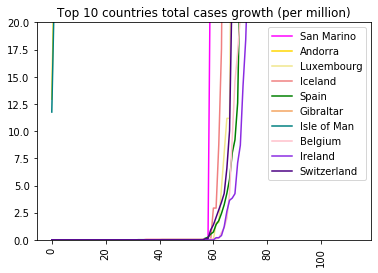

In [21]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth (per million)',
                            0, 20)

The growth increase very fast. A common starting point for comparison could be 2.5 cases per million of inhabitants.

Plot the growth starting from the point where the rate was upper than 2.5 cases per million of inhabitants.

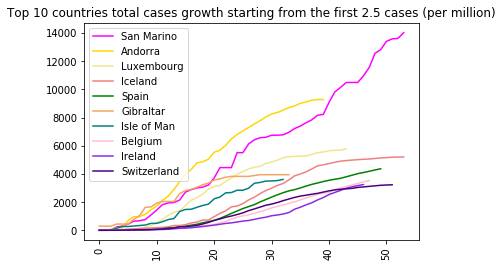

In [22]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth starting from the first 2.5 cases (per million)',
                            2.5)

It is interesting to see how small countries have a higher concentration of deaths and cases. This data highlights that the virus is present principally in some parts of each country. To demonstrate this opinion let's try to see the same data about big countries, such as China and USA. @IN FASE DI MODIFICA

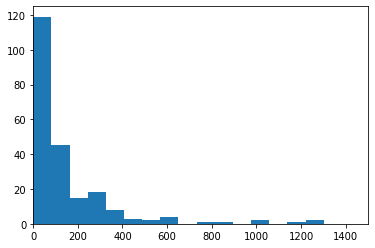

In [23]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200)
plt.xlim(0, 1500) 
plt.show()


In [24]:
df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())].sort_values(by = 'Population density')

,Country,Population density
195,Sweden,20.0
98,Ireland,57.8
190,Spain,80.0
69,France,111.3
4,Andorra,152.1
101,Italy,193.0
213,United Kingdom,247.6
19,Belgium,340.0
146,Netherlands,397.1
177,San Marino,479.5


In [25]:
df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())].sort_values(by = 'Population density')

,Country,Population density
93,Iceland,2.9
98,Ireland,57.8
190,Spain,80.0
99,Isle of Man,131.9
4,Andorra,152.1
196,Switzerland,182.2
121,Luxembourg,183.5
19,Belgium,340.0
177,San Marino,479.5
78,Gibraltar,3989.7


In [26]:
df_total_deaths_x_million_ = df_total_deaths_x_million.copy()
df_total_deaths_x_million_.set_index('Country', inplace = True)
print('Total deaths per million:')
print('China:',df_total_deaths_x_million_.loc['China'].values.max())
print('United States:',df_total_deaths_x_million_.loc['United States'].values.max())
print('Mean of the top 10 countries:',top_10_total_deaths_x_million['Total deaths per million of inhabitants'].mean())
df_total_cases_x_million_ = df_total_cases_x_million.copy()
df_total_cases_x_million_.set_index('Country', inplace = True)
print('\nTotal cases per million:')
print('China:',df_total_cases_x_million_.loc['China'].values.max())
print('United States:',df_total_cases_x_million_.loc['United States'].values.max())
print('Mean of the top 10 countries:',top_10_total_cases_x_million['Total cases per million of inhabitants'].mean())


Total deaths per million:
China: 3.2209570058543937
United States: 136.14090359656967
Mean of the top 10 countries: 416.32382944242136

Total cases per million:
China: 58.266250720227106
United States: 2492.5510339794832
Mean of the top 10 countries: 5623.868304769378


These final data demonstrate the previous consideration.

## Focus on the number of new deaths an new cases.

Print data of the top ten day/country for new deaths

In [27]:
#copy the dataframe
df_new_deaths = df_all_data[['Date','Country','New deaths']].copy()
#delete the row regarding the entire world
df_new_deaths = df_new_deaths[df_new_deaths['Country'] != 'World']
#sort the data in descending order and print the top 10 rows
df_new_deaths.sort_values(by = 'New deaths', ascending = False, inplace = True)
df_new_deaths.head(10)

,Date,Country,New deaths
10645,2020-04-16,United States,4928
10647,2020-04-18,United States,3770
10651,2020-04-22,United States,2524
10644,2020-04-15,United States,2408
10646,2020-04-17,United States,2299
10640,2020-04-11,United States,2087
3521,2020-04-04,France,2004
10638,2020-04-09,United States,1922
10637,2020-04-08,United States,1906
10639,2020-04-10,United States,1873


Evaluate the moving average for new deaths taking in consideration a period of 10 days.

In [28]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new deaths for the row date
df_matrix_new_deaths = get_matrix_dataset(df_, 'New deaths')
df_matrix_new_deaths.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
2020-04-18,1,0,16,2,0,0,7,1,1,4,...,2,847,3770,0,0,0,0,0,0,0
2020-04-19,0,0,3,0,0,0,10,0,0,2,...,2,888,1856,0,1,0,0,0,0,0
2020-04-20,3,0,8,1,0,0,2,2,0,1,...,4,596,1772,1,0,0,0,0,1,0
2020-04-21,2,0,9,0,0,0,8,2,0,1,...,2,449,1857,0,0,0,0,0,0,0
2020-04-22,1,0,8,1,0,0,9,0,0,3,...,3,828,2524,2,1,1,0,0,0,0


In [29]:
#evaluate the moving average of the new cases matrix
df_new_deaths_moving_average_ = df_matrix_new_deaths.copy()
df_new_deaths_moving_average_ = evaluate_moving_average(df_new_deaths_moving_average_, 10)
df_new_deaths_moving_average_.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-18,0,1,14,1,0,0,3,0,0,2,...,0,461,928,0,0,0,0,0,0,0
2020-04-19,0,1,16,1,0,0,4,0,0,3,...,1,514,1070,0,0,0,0,0,0,0
2020-04-20,1,1,17,1,0,0,4,0,0,3,...,1,586,1230,0,0,0,0,0,0,0
2020-04-21,1,1,20,1,0,0,5,0,0,3,...,0,657,1352,0,0,0,0,0,0,0
2020-04-22,1,0,21,1,0,0,5,0,0,3,...,1,716,1469,0,0,0,0,0,0,0


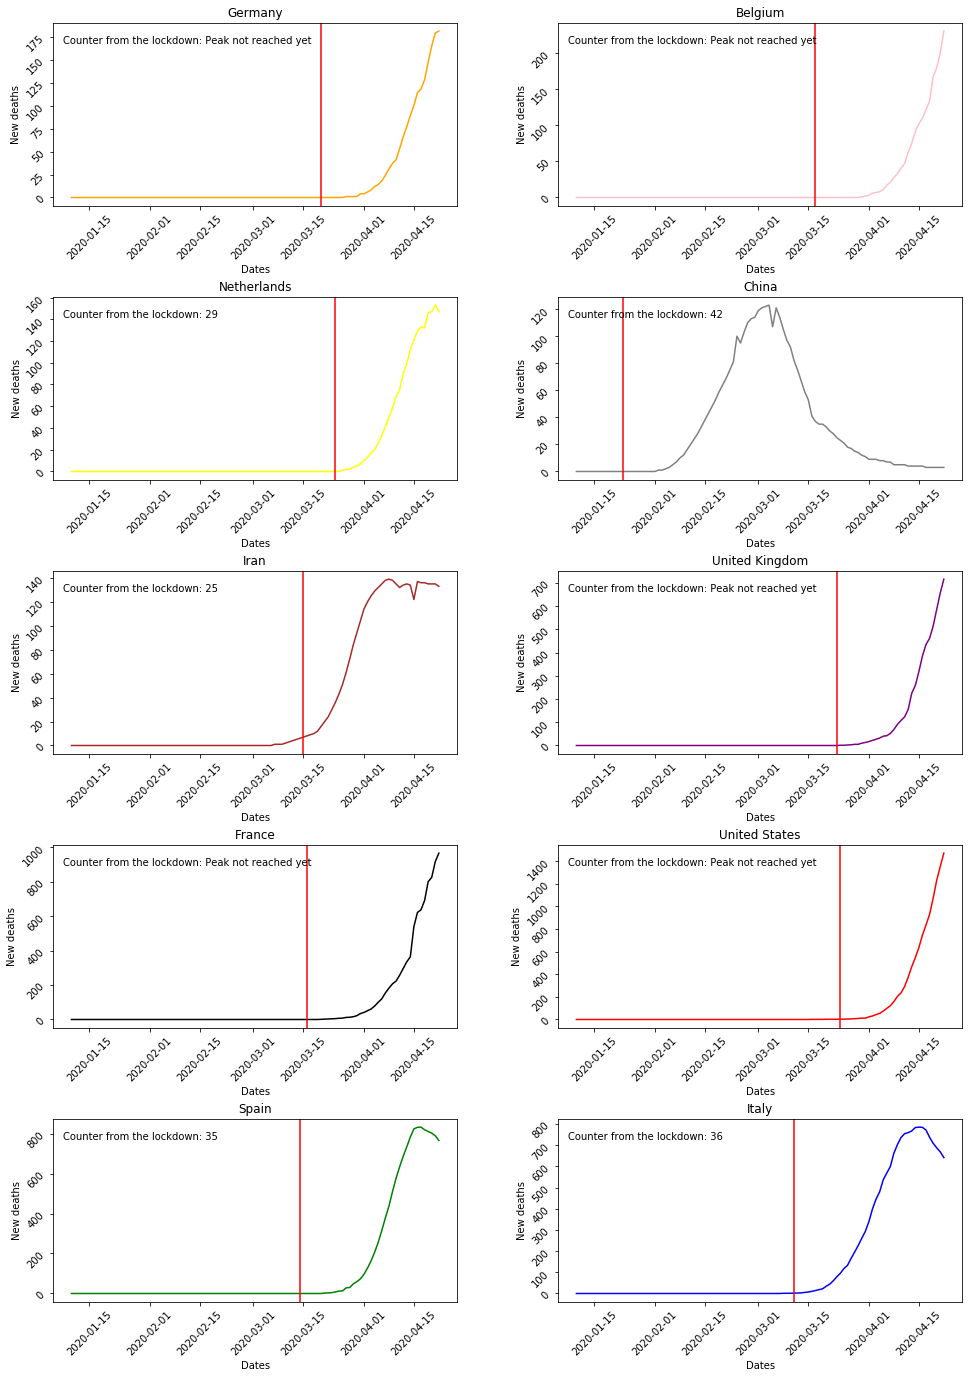

In [59]:
#calculating the top then for deaths making the sum of all the deaths and plotting it
max_deaths=df_new_deaths_moving_average_.sum(axis = 0, skipna = True)
top_ten_new_deaths_moving_average=max_deaths.sort_values()[-10:].index

plotWithLockdown(top_ten_new_deaths_moving_average,df_lockdown,df_new_deaths_moving_average_,'New deaths')


Print data of the top ten day/country for new cases

In [49]:
#copy the dataframe
df_new_cases = df_all_data[['Date','Country','New cases']].copy()
#delete the row regarding the entire world
df_new_cases = df_new_cases[df_new_cases['Country'] != 'World']
df_new_cases.sort_values(by = 'New cases', ascending = False, inplace = True)
df_new_cases.head(10)

,Date,Country,New cases
10651,2020-04-22,United States,37289
10640,2020-04-11,United States,35527
10634,2020-04-05,United States,34272
10639,2020-04-10,United States,33901
10638,2020-04-09,United States,33323
10648,2020-04-19,United States,32922
10633,2020-04-04,United States,32425
10646,2020-04-17,United States,31667
10647,2020-04-18,United States,30833
10637,2020-04-08,United States,30613


Evaluate the moving average for new cases taking in consideration a period of 10 days.

In [50]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new cases for the row date
df_matrix_new_cases = get_matrix_dataset(df_, 'New cases')
df_matrix_new_cases.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
2020-04-18,51,21,150,14,0,0,98,47,1,36,...,0,5599,30833,18,70,23,1,0,4,0
2020-04-19,63,9,117,8,5,0,170,43,0,53,...,477,5525,32922,18,45,0,0,0,5,1
2020-04-20,88,14,94,9,0,0,102,48,1,26,...,479,5850,24601,4,70,29,0,0,4,0
2020-04-21,35,22,89,4,0,0,90,62,0,13,...,484,4676,28065,10,92,0,0,0,4,0
2020-04-22,61,25,93,0,0,0,112,72,0,22,...,490,4301,37289,11,35,29,0,0,0,3


In [51]:
#evaluate the moving average of the new cases matrix
df_new_cases_moving_average_ = df_matrix_new_cases.copy()
df_new_cases_moving_average = evaluate_moving_average(df_new_cases_moving_average_, 20)
df_new_cases_moving_average.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-18,4,9,19,13,0,0,34,18,1,165,...,18,716,5212,11,5,5,7,0,0,0
2020-04-19,5,9,21,15,0,0,36,21,1,186,...,21,840,6205,15,6,5,9,0,1,0
2020-04-20,5,10,24,16,0,0,40,21,2,199,...,20,960,7113,15,7,5,9,0,1,0
2020-04-21,6,10,28,18,0,0,47,24,2,222,...,26,1088,8179,16,7,6,9,0,1,0
2020-04-22,7,11,34,18,0,0,47,26,2,229,...,29,1234,9415,16,8,6,9,0,1,0


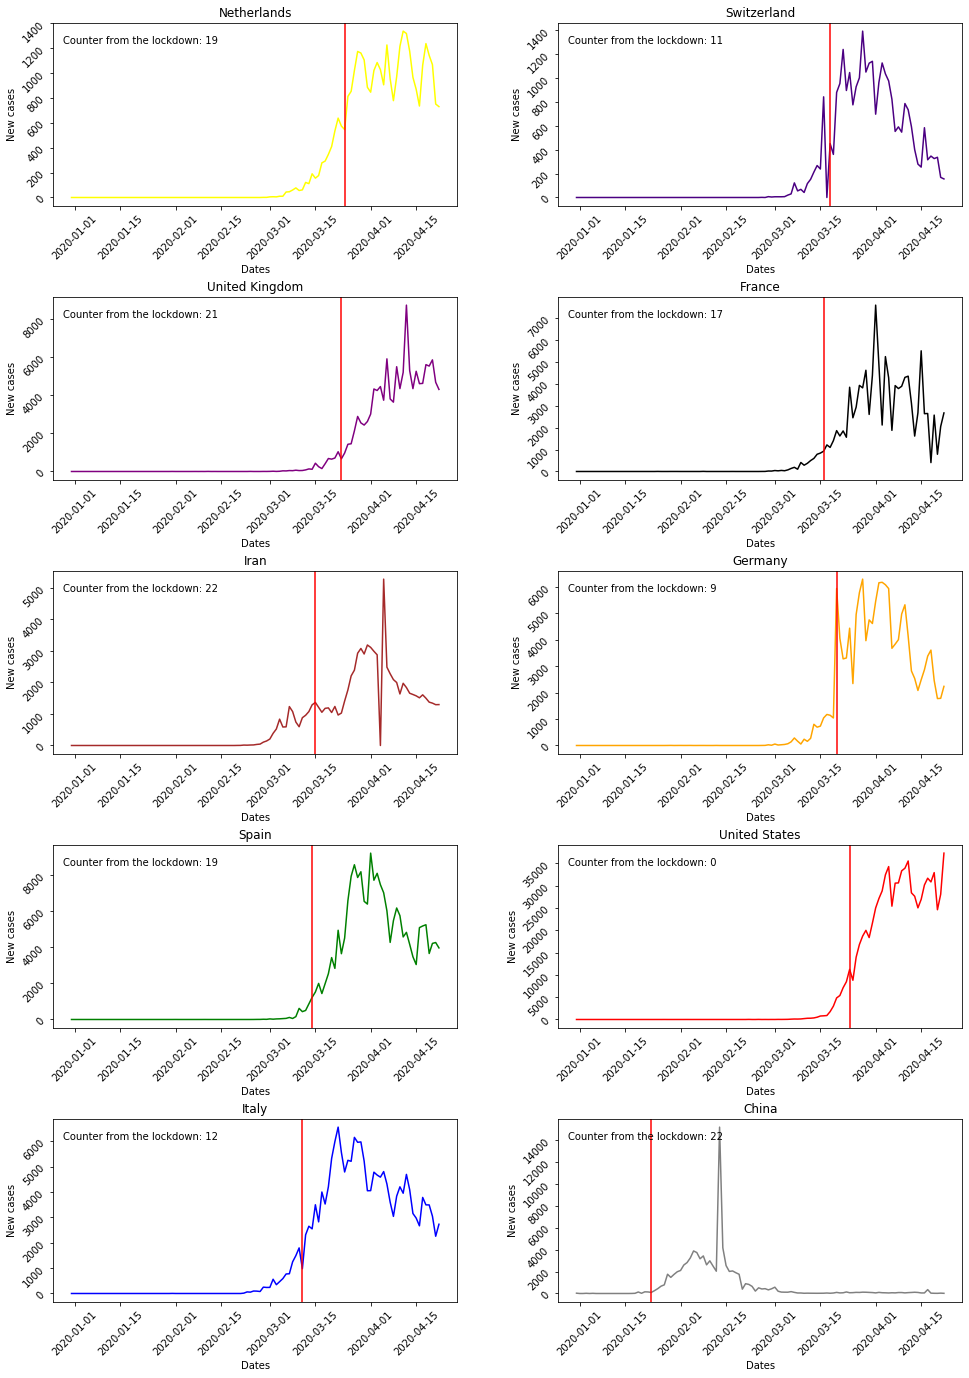

In [54]:
max_cases=df_new_cases_moving_average.sum(axis = 0, skipna = True)
top_ten_new_cases_moving_average=max_cases.sort_values()[-10:].index

plotWithLockdown(top_ten_new_cases_moving_average,df_lockdown,df_new_cases_moving_average_,'New cases')

## Analysis of the percentage of growth

Create a dataframe with the total deaths grow rate for each country day by day.

In [85]:
df_total_deaths = df_all_data[['Date','Country','Total deaths']].copy()
death_growth_rate = evaluateGrowthRate(df_total_deaths, 1, 'Total deaths')

Plot the death grow rate of the top 5 countries for death.

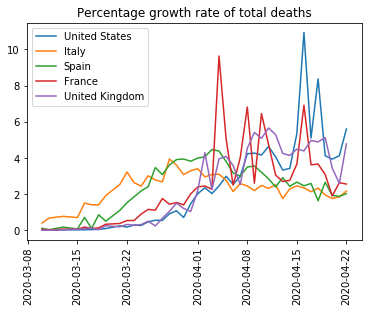

In [105]:
#get the list of the top 5 countries
top_5_death_countries_list = top_10_total_deaths['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_deaths_growth = death_growth_rate[top_5_death_countries_list]

some_countries_deaths_growth=some_countries_deaths_growth[some_countries_deaths_growth>0]
some_countries_deaths_growth=some_countries_deaths_growth.dropna()
for country in top_5_death_countries_list:
    plt.plot(some_countries_deaths_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total deaths")
plt.show()

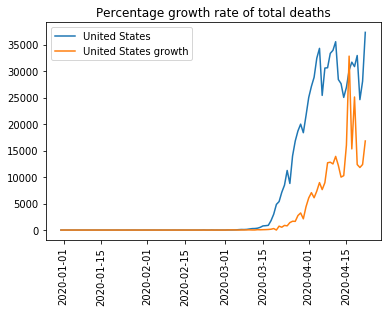

In [100]:
plt.plot(df_matrix_new_cases.index,df_matrix_new_cases['United States'], label = 'United States')

plt.plot(some_countries_deaths_growth.index,some_countries_deaths_growth['United States']*3000, label = 'United States growth')


plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total deaths")
plt.show()

Create a dataframe with the total cases grow rate for each country day by day.

In [87]:
df_total_cases = df_all_data[['Date','Country','Total cases']].copy()
case_growth_rate = evaluateGrowthRate(df_total_cases, 1, 'Total cases')

Plot the grow rate of the top 5 countries for number of cases.

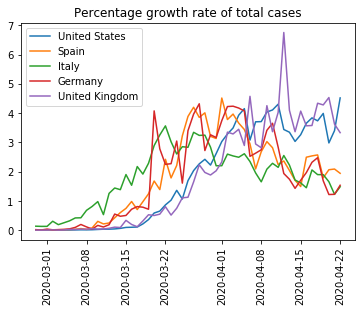

In [106]:
#get the list of the top 5 countries
top_5_case_countries_list = top_10_total_cases['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_cases_growth = case_growth_rate[top_5_case_countries_list]
some_countries_cases_growth=some_countries_cases_growth[some_countries_cases_growth>0]
some_countries_cases_growth=some_countries_cases_growth.dropna()
for country in top_5_case_countries_list:
    plt.plot(some_countries_cases_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total cases")
plt.show()